In [1]:

# %config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
from xgboost import XGBClassifier
import random

import matplotlib as matplot
import matplotlib.pyplot as plt
# %matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings, os 
# warnings.filterwarnings("ignore")

# from keras import Sequential
# from keras.models import Model, load_model
# from keras.layers import *
# from keras.callbacks import ModelCheckpoint
# from keras import regularizers
from matplotlib import pyplot as plt

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA, TruncatedSVD, PCA
from sklearn.svm import LinearSVC

import xgboost
# from mlxtend.classifier import EnsembleVoteClassifier 
import shap
import sklearn.neighbors

from deepod.models import PReNet
from collections import Counter
# from modAL.models impor ActiveLearner, Committee
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
import copy
from itertools import combinations, product
from sklearn.datasets import make_classification
# from alipy import ToolBox
# from alipy.utils.misc import nsmallestarg, randperm, nlargestarg

### Preprocess Data

In [2]:
# dataset_csv_path = './Dataset/CSECICIDS2018_improved'
dataset_csv_path = './Dataset/CICIDS2017_improved'
csv_file_names = os.listdir(dataset_csv_path)[:]
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
def read_csv():
    complete_paths = []
    for csv_file_name in csv_file_names:
        complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

    improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                            ignore_index = True)
   
    improved_df = clean_df(improved_df)

    improved_df['Label'].value_counts()  
      
    return improved_df
cicids_df = read_csv()

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)


In [6]:
cicids_df['Label'].value_counts()
cicids_df['Attempted Category'].value_counts()
attepmted_labels = [s for s in cicids_df['Label'].unique() if 'Attempted' in s]

cicids_df.drop(['Attempted Category'], axis = 1, inplace = True)

cicids_df.replace(attepmted_labels, 'BENIGN', inplace = True)
cicids_df['Label'].value_counts()

BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: Label, dtype: int64

KeyError: 'Attempted Category'

In [ ]:
# cicids_df["Label"].value_counts().plot(kind='bar', stacked=True)
# pd.DataFrame(cicids_df["Label"].value_counts()).T.plot(kind='bar', stacked=True)


In [5]:
dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                'Dst Port', 'Timestamp']
cicids_df.drop(dropping_cols, axis=1, inplace=True)

cicids_scaler = StandardScaler()
y = cicids_df["Label"]  # Extract labels
X = cicids_df.drop(columns=["Label"])  # Extract features
X_scaled = pd.DataFrame(cicids_scaler.fit_transform(X), columns=X.columns)  # Scale features

# Combine scaled features and labels
cicids_df_scaled = X_scaled.copy()
cicids_df_scaled["Label"] = y

# Check the resulting DataFrame
cicids_df_scaled.head()


,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,3.457206,0.251017,-0.012270,-0.054524,-0.008343,-0.427369,-0.606049,-0.542756,-0.391062,-0.547484,...,18.275408,-0.131877,0.593958,1.880174,1.104872,0.172649,-0.011963,-0.014461,-0.082193,BENIGN
1,1.710282,-0.007492,-0.007088,-0.026996,-0.008233,-0.329765,0.764480,-0.019357,-0.391062,-0.526153,...,1.048778,2.018078,4.287819,-0.109085,4.092575,4.389093,-0.011963,-0.014461,-0.082193,BENIGN
2,3.272155,0.292378,-0.012270,1.899921,-0.008343,-0.116256,0.450400,0.292289,-0.106479,-0.547484,...,8.822260,-0.131881,1.516189,6.964019,3.024593,0.096655,-0.011963,-0.014461,-0.082193,BENIGN
3,1.759459,-0.005194,-0.005361,-0.017819,-0.008196,-0.329765,0.764480,-0.019357,-0.391062,-0.526153,...,8.863924,15.619113,3.708500,-0.109085,3.537359,3.798947,-0.011963,-0.014461,-0.082193,BENIGN
4,1.791939,-0.005194,-0.005361,-0.017819,-0.008196,-0.329765,0.764480,-0.019357,-0.391062,-0.526153,...,8.871236,15.631839,3.779585,-0.109085,3.605486,3.871360,-0.011963,-0.014461,-0.082193,BENIGN


In [ ]:
#! a
cicids_df = cicids_df_scaled.copy()

In [7]:
atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan"]
for atk in atk_list:
    print(cicids_df[cicids_df["Label"] == atk].shape)

(159066, 82)
(158468, 82)
(95144, 82)
(71767, 82)


In [8]:
# Shuffle the Benign Data
benign_df = cicids_df.loc[cicids_df["Label"] == "BENIGN"]
benign_df = benign_df.sample(frac=1).reset_index(drop=True)
benign_df

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time,Label
0,85992,1,1,42,145,42,42,42.000000,0.000000,145,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
1,118629415,19,16,865,1492,427,0,45.526316,134.430638,746,...,3251257,36663,9.995409e+06,15162.111675,10000572,9949708,0,0,118629415,BENIGN
2,197,2,2,60,264,30,30,30.000000,0.000000,132,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
3,158,2,2,72,136,36,36,36.000000,0.000000,68,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
4,120093,2,2,72,380,36,36,36.000000,0.000000,190,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594535,119432711,72,98,5986,148516,1456,0,83.138889,261.415449,4344,...,3746869,23092,1.020813e+07,28973.091451,10216914,10120770,0,0,119432711,BENIGN
1594536,348,2,2,60,264,30,30,30.000000,0.000000,132,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
1594537,479,1,1,56,116,56,56,56.000000,0.000000,116,...,0,0,0.000000e+00,0.000000,0,0,0,0,0,BENIGN
1594538,179322,11,9,534,6704,197,0,48.545455,78.817972,2920,...,0,0,0.000000e+00,0.000000,0,0,0,0,179322,BENIGN


### Defining Global and Local Model

In [9]:
def set_supervised_label(supervision_rate, y, idx):
        if supervision_rate == 0:
            y[idx[:2]] = 1
        else:
            idx = np.random.choice(idx, size=int(supervision_rate * len(idx)), replace=False)
            y[idx] = 1
        return y
      
def get_optimal_threshold(precision, recall, thresholds):
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores[np.isnan(f1_scores)] = 0  # Replace NaN values with 0    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold  
      
class Global_Model():
  def __init__(self, initial_data):
      self.initial_data = initial_data.copy() #Initially Empty
      self.gm_data = pd.DataFrame(columns=initial_data.columns)
      self.gm_retrain(supervision=1.0)


  def gm_retrain(self, new_gm_data=None, supervision=0):
      if new_gm_data is None:
        #   training_data = self.gm_data
        pass
      else:
        
          # Combine new data with existing GM data
          self.gm_data = pd.concat([self.gm_data, new_gm_data], ignore_index=True)
          # Extract labels and drop label column
          
          
      training_data = pd.concat([self.initial_data, self.gm_data], ignore_index=False)
      print("GM Training Data Size", training_data.shape)
      label = training_data["Label"].values
      training_data = training_data.drop(columns=["Label"])
      # Train-test split
      X_train, X_test, y_train, y_test = train_test_split(
          training_data, label, shuffle=True, test_size=0.2, random_state=4022
      )

      # Prepare labels for semi-supervised learning
      idx = np.where(y_train == 1)[0]
      y_train = np.zeros_like(y_train)  # Initialize with zeros
      y_train = set_supervised_label(supervision, y_train, idx)

      # Train the model
      model = PReNet
      self.clf = model(device="cuda", verbose=1, epochs=1)
      self.clf.fit(X_train.to_numpy(), y=y_train)
      
      # Calculate optimal threshold
      anomaly_scores = self.clf.decision_function(X_test.to_numpy())
      precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores)
      opt_threshold = get_optimal_threshold(precision, recall, thresholds)
      self.opt_threshold = opt_threshold      

      # Perform inference to evaluate the model
      output, anomaly_scores = self.perform_inference(X_test)
    #   return clf, model
              
  def perform_inference(self, X, y_real=None):  
      anomaly_scores = self.clf.decision_function(X.to_numpy())
      output = np.where(anomaly_scores > self.opt_threshold, 1,0)
      
      print(np.unique(output)) 
      if y_real is not None:
          print("Accuracy of GM: ", accuracy_score(output, y_real))
      return output, anomaly_scores

In [10]:
class Local_Model():
    def __init__(self, gm):
        self.model = XGBClassifier(objective='binary:logistic', verbosity=0)
        # self.model = DecisionTreeClassifier(criterion='entropy', max_depth=5,  
        #                                     min_samples_leaf=10, 
        #                                     # ccp_alpha=0.01, #Pruning coef
        #                                     random_state=4022)
        self.state = 0 #0: OFF, 1: ON, 2: HYBRID
        self.global_model = gm 
        self.lm_data = pd.DataFrame()
                
    def retrain_model(self, new_lm_data, threshold = 0.2, update_gm = False): #Select Most Important Data and Upload Newly Recorded Data
        # TODO: Use AL to Select Prerecorded Data
        # known_df = self.load_known_df()
        # filtered_new_data, informative_score_list, updated_model = self.select_data(known_df, X_new, threshold, y_new)
        # labeled_new_data = self.upload_gm(filtered_new_data)
        
        # if update_gm:
        #     filtered_new_data["Label"] = 0
        #     self.global_model.update_data(filtered_new_data)
        # # TODO: After updating return the labels or recall the function
        # else:
        
        y_real = new_lm_data["Label"].copy()
        X_new = new_lm_data.drop(columns=["Label"]).copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X_new, y_real, shuffle=True, test_size=0.2, random_state=4022
        )

        # Use the global model to inquire labels for X_train
        y_new = self.inquire_gm(X_train, y_train)

        # Combine X_train and the inferred labels into a DataFrame
        new_training_data = X_train.copy()
        new_training_data["Label"] = y_new

        # Append new training data to the local model's data
        self.lm_data = pd.concat([self.lm_data, new_training_data], ignore_index=True)

        # Retrain the local model using the updated data
        self.model.fit(self.lm_data.drop(columns=["Label"]), self.lm_data["Label"])

        # Evaluate the updated model (optional, based on your implementation)
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_pred, y_test)

        return acc
        
    def inquire_gm(self, X_query, y_real=None): 
        # X_query_scaled = self.scaler.transform(X_query)
        pseudo_label, _ = self.global_model.perform_inference(X_query, y_real)
        X_query_df = pd.DataFrame(X_query)
        # X_query_df["Label"] = pseudo_label
        return pseudo_label
    
    def perform_inference(self, X):
        output = self.model.predict(X) 
        print(np.unique(output)) 
        return output    
    
    def select_data(self, known_df, X_new, threshold, y_new):
        round = 10
        informative_score_list = []
        y_new = np.ones(X_new.shape[0]) * 2 if y_new is None else y_new
        model = self.model
        
        X_known = known_df.drop(columns=["Label"], inplace = False).copy()
        y_known = known_df["Label"]
        # X_known.drop(columns=["Src IP", "Dst IP"], inplace=True)
        X = pd.concat([X_known, X_new], ignore_index=True)
        y = np.concatenate([y_known, y_new]).astype(int)
        print(y)
        label_ind = np.arange(len(X_known))
        print("Size of Label Index", len(X_known))
        unlab_ind = np.arange(len(X_known), len(X))

        divided_arrays = np.array_split(unlab_ind, round)
        
        alibox_new = ToolBox(X=X, y=y, query_type='AllLabels', saving_path=None,) 
        alibox_new.split_AL(test_ratio=0.1, initial_label_rate=0.1, split_count=10)     
        strategy_name = "QueryInstanceUncertainty"
        strategy = alibox_new.get_query_strategy(strategy_name=strategy_name) #TODO Replace Alibox with a single function
        for i in range(round):
            batch_size = 1000 
            print(f"Round {i}")
            # Use AL to Select Data

            
            select_ind, informative_score = strategy.select(label_index=label_ind, unlabel_index=divided_arrays[i], 
                                                            threshold=threshold, custom = True, model=model, batch_size=batch_size)
            print(select_ind)
            # select_ind = select_ind[np.where(np.array(informative_score) > threshold)[0]]
                              
            batch_size = min(batch_size, np.shape(select_ind)[0] ) #Limit up to 30 000 per query
            print(batch_size)
            # Upload Data to GM
            idx_to_query = select_ind[:batch_size]
            if len(idx_to_query) > 0:
                if 2.0 in y_new: 
                    pseudo_labels = self.inquire_gm(X.iloc[idx_to_query]) 
                    y[idx_to_query] = pseudo_labels 
                else: # ? Set GM to be 100% Accurate
                    pseudo_labels = y[idx_to_query]
                    # y[idx_to_query] = pseudo_labels
                print(f"New Label Counts: {Counter(y[select_ind[:batch_size]])}")    
                label_ind = np.concatenate([label_ind, select_ind[:batch_size]])# label_ind.update(select_ind)
                mask = np.where(np.isin(unlab_ind, select_ind[:batch_size], invert=True)) # unlab_ind.difference_update(select_ind)
                unlab_ind = unlab_ind[mask]
                
                print(f"Added {batch_size} Shape of Label_ind: {np.shape(label_ind)}")  
                #Update The Model
                X_scaled = self.scaler.transform(X.iloc[label_ind]) 
                print("Number of duplicates", len(label_ind) - len(np.unique(label_ind)))
                model = self.model
                print(label_ind)
                print(f"np.unique: {np.unique(y[label_ind])}")
                model.fit(X=X_scaled, y=y[label_ind]) 
                # pred = model.predict(X_test)
                # query_accuracy = metric(pred, y_test)      
            else:
                print("No Data Added")
            print(informative_score[:100])
            informative_score_list.append(informative_score)

            
        merged_train_df = pd.DataFrame(X.iloc[label_ind], columns = features[2:])
        merged_train_df["Label"] = y[label_ind]
        new_train_df = merged_train_df.iloc[len(X_known):]
        return new_train_df, informative_score_list, model
        



### Defining Area

In [11]:
class Attack:
    def __init__(self, name, centroid, std_dev, data):
        self.name = name
        self.centroid = centroid
        self.std_dev = std_dev
        self.data = data
        self.active = False
        self.rr_counter = 0  # Round Robin Counter
        self.first_seen = random.uniform(0,30)

    def get_data(self):
        chunk_size = self.data.shape[0] // 10  # Divide into 10 chunks
        start_idx = self.rr_counter * chunk_size
        end_idx = start_idx + chunk_size
        if self.rr_counter == 9:
            end_idx = self.data.shape[0]  # Include all remaining rows
        self.rr_counter = (self.rr_counter + 1) % 10
        return self.data.iloc[start_idx:end_idx]

def define_edge_area(num_edge_area, gm=None):
    area_list = [Edge_Area((random.uniform(0, 1), random.uniform(0, 1)), gm) for _ in range(num_edge_area)]
    for edge_area in area_list:
        centroid = edge_area.centroid
        distances = [
            np.sqrt((other_area.centroid[0] - centroid[0])**2 + (other_area.centroid[1] - centroid[1])**2)
            for other_area in area_list
        ]
        # Get the indices of the two smallest distances, excluding itself
        closest_indices = np.argsort(distances)[1:3]  # Skip the first (distance to itself)
        edge_area.knowledge_pool = [area_list[i] for i in closest_indices]
    return area_list

def define_atk(atk_list, edge_area_list, cicids_df, benign_df):
    atk_info_dict = {}
    anomaly_ratio = 10
    benign_idx = 0
    for idx, atk in enumerate(atk_list):
        # Cycle through edge areas
        edge_area = edge_area_list[idx % len(edge_area_list)]

        # Define standard deviations
        std_dev = (random.uniform(0.2, 0.4), random.uniform(0.2, 0.4))

        # Offset the attack centroid relative to the edge area centroid
        atk_centroid = (
            edge_area.centroid[0] + random.uniform(-std_dev[0], std_dev[0]) / 3,
            edge_area.centroid[1] + random.uniform(-std_dev[1], std_dev[1]) / 3
        )

        # Filter attack-specific data
        atk_data = cicids_df.loc[cicids_df["Label"] == atk]

        # Get corresponding benign data based on anomaly ratio
        benign_count = atk_data.shape[0] * anomaly_ratio
        benign_data = benign_df.iloc[benign_idx: benign_idx + benign_count]
        benign_idx += benign_count

        # Ensure benign_idx doesn't exceed benign_df bounds
        if benign_idx > len(benign_df):
            benign_idx = len(benign_df)  # Prevent index out of bounds
            print("Index Out of Bounds", atk)

        # Concatenate benign and attack data
        data = pd.concat([benign_data, atk_data], ignore_index=True)
        data = data.sample(frac=1).reset_index(drop=True)
        data["Label"] = data["Label"].map({"BENIGN": 0}).fillna(1)

        # Create and store an Attack object
        atk_info_dict[atk] = Attack(atk, atk_centroid, std_dev, data)

    return atk_info_dict


class Edge_Area:
    def __init__(self, centroid, gm=None):
        self.centroid = centroid
        self.seen_attack_acc = dict() # Values as List of (t, acc)
        if gm != None:
            self.local_model = Local_Model(gm)
    def create_knowledge_sharing_pool(self):
        # TODO: Get the closest based on euclidean distance
        self.sharing_pool = None
    def train_local_model(self, new_lm_data):
        return self.local_model.retrain_model(new_lm_data)



Index Out of Bounds DoS Hulk
Index Out of Bounds Portscan
Index Out of Bounds DDoS
Index Out of Bounds Infiltration - Portscan


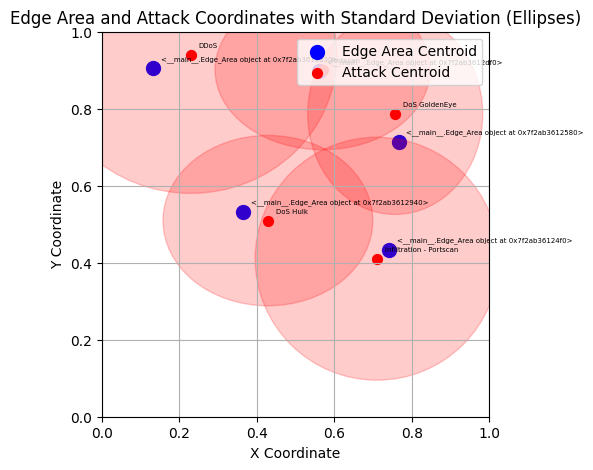

In [12]:
from matplotlib.patches import Ellipse

# Function to visualize edge areas and attack coordinates with standard deviation as ellipses
def visualize_edge_area_and_attacks_with_ellipses(edge_area_list, atk_info_list):
    plt.figure(figsize=(5, 5))
    
    # Plot edge area centroids
    for edge_area in edge_area_list:
        plt.scatter(edge_area.centroid[0], edge_area.centroid[1], c='blue', label='Edge Area Centroid', s=100)
        plt.text(edge_area.centroid[0] + 0.02, edge_area.centroid[1] + 0.02, edge_area, fontsize=5)
    
    # Plot attack centroids with standard deviation
    for attack in atk_info_list:
        plt.scatter(attack.centroid[0], attack.centroid[1], c='red', label='Attack Centroid', s=50)
        plt.text(attack.centroid[0] + 0.02, attack.centroid[1] + 0.02, attack.name, fontsize=5)
        
        # Plot standard deviation as an ellipse around the centroid
        std_x, std_y = attack.std_dev
        ellipse = Ellipse(
            xy=attack.centroid,
            width=2 * std_x,  # Full width of the ellipse
            height=2 * std_y,  # Full height of the ellipse
            edgecolor='red',
            facecolor='red',
            alpha=0.2
        )
        plt.gca().add_patch(ellipse)
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    plt.title("Edge Area and Attack Coordinates with Standard Deviation (Ellipses)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
    

num_edge_areas = 5
edge_area_list = define_edge_area(num_edge_areas)

atk_list = ["DoS GoldenEye", "DoS Hulk", "Portscan", "DDoS", "Infiltration - Portscan"]
atk_info_dict = define_atk(atk_list, edge_area_list, cicids_df_scaled, benign_df)
visualize_edge_area_and_attacks_with_ellipses(edge_area_list, atk_info_dict.values())


# Bivariate Normal Distribution

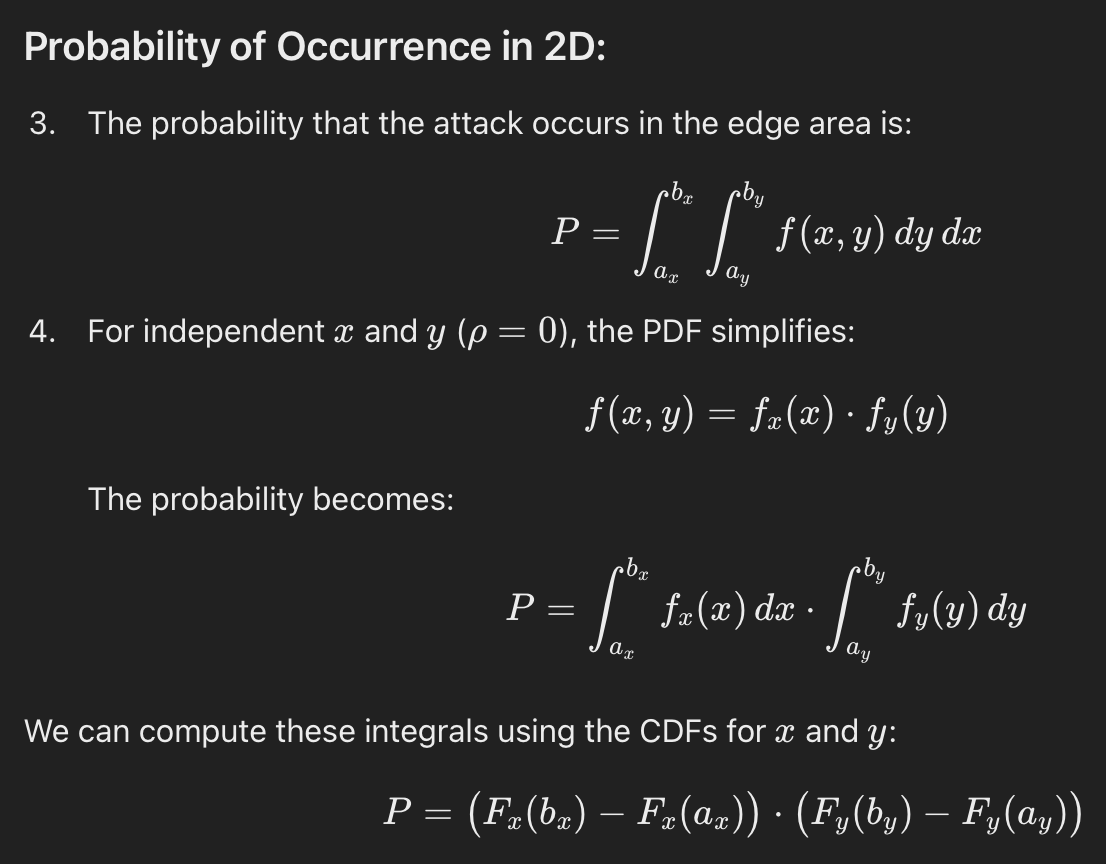

In [13]:
from scipy.stats import norm

def probability_in_2d_edge_area(mu_x, sigma_x, mu_y, sigma_y, area_centroid_x, area_centroid_y):
    (a_x, b_x) = (area_centroid_x-0.1, area_centroid_x+0.1)
    (a_y, b_y) = (area_centroid_y-0.1, area_centroid_y+0.1)

    # Probability in x-dimension
    p_x = norm.cdf(b_x, loc=mu_x, scale=sigma_x) - norm.cdf(a_x, loc=mu_x, scale=sigma_x)
    # Probability in y-dimension
    p_y = norm.cdf(b_y, loc=mu_y, scale=sigma_y) - norm.cdf(a_y, loc=mu_y, scale=sigma_y)

    # Total probability in the 2D region
    return p_x * p_y

# Example usage
mu_x, sigma_x = 0.5, 0.1  # Mean and std deviation for x
mu_y, sigma_y = 0.5, 0.1  # Mean and std deviation for y
area_centroid_x, area_centroid_y = (0.4, 0.4)  # Edge area bounds for x and y

probability = probability_in_2d_edge_area(mu_x, sigma_x, mu_y, sigma_y, area_centroid_x, area_centroid_y)
print(f"Probability of attack occurring in the edge area: {probability:.4f}")


Probability of attack occurring in the edge area: 0.2278


### Initial Training of Local and Global Model

Global Model = 3 Atk, 
Local Model = None

In [14]:
cicids_df = cicids_df_scaled.copy()
#### Sample out Malicious data such that it would become an outlier
print(f'improved_df.shape {cicids_df.shape} Before Sampling Out')
cicids_df = pd.concat([cicids_df[cicids_df['Label'] == 'BENIGN'], cicids_df[cicids_df['Label'] != 'BENIGN'].sample(frac=0.3, random_state=42)]) 
print(f'improved_df.shape {cicids_df.shape} after Sampling Out')
ratio = cicids_df.loc[cicids_df["Label"] == "BENIGN"].shape[0]/ cicids_df.loc[cicids_df["Label"] != "BENIGN"].shape[0]
print(f'Ratio of Benign to Anomaly is {ratio} : 1')

improved_df.shape (2099971, 82) Before Sampling Out
improved_df.shape (1746166, 82) after Sampling Out
Ratio of Benign to Anomaly is 10.515890550085405 : 1


In [15]:
num_edge_areas = 5
edge_area_list = define_edge_area(num_edge_areas)

# atk_list = ["Portscan", "DoS Hulk", "DDoS", "DoS DoS Hulk", "Infiltration - Portscan"]
atk_list = ["Portscan", "DoS Hulk", "DDoS", "Infiltration - Portscan", "DoS GoldenEye", "FTP-Patator", "DoS Slowloris", "SSH-Patator", "DoS Slowhttptest"]
atk_info_dict = define_atk(atk_list, edge_area_list, cicids_df, benign_df)
#TODO: Randomly choose 3 attacks from the list, set the first_seen_t = 0, train the global model using this 3 attacks

first_seen_atk = ["DoS Hulk", "DDoS"]
gm_training_data = pd.DataFrame()
# Set Training Data for GM
for atk in first_seen_atk:
    # curr_atk_df = cicids_df.loc[cicids_df["Label"] == atk].copy()
    curr_atk_df = atk_info_dict[atk].data.copy()
    curr_atk_df = curr_atk_df.sample(frac=0.3).reset_index(drop=True)
    gm_training_data = pd.concat([gm_training_data, curr_atk_df], ignore_index=True) #Train with 0.2 of the attack data

    # gm_training_data["Label"] = gm_training_data["Label"].map({"BENIGN":0}).fillna(1)
    # gm_training_data = gm_training_data.sample(frac=1).reset_index(drop=True)
    
y = gm_training_data["Label"].copy()

# gm_training_data = pd.DataFrame(scaler.fit_transform(gm_training_data), columns = curr_atk_df.columns)
gm_training_data["Label"] = y
# gm = Global_Model(gm_training_data)

In [16]:
X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(
    gm_training_data.drop(columns=["Label"]), gm_training_data["Label"], shuffle=True, test_size=0.2, random_state=4022
)
# X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(
#     cicids_df_scaled.drop(columns=["Label"]), cicids_df_scaled["Label"].map({"BENIGN": 0}).fillna(1), shuffle=True, test_size=0.2, random_state=4022
# )

### Start Simulation

In [17]:
# TODO: Compare Different Epochs
atk_list = ["Portscan", "DoS Hulk", "DDoS"]
X_gm_train["Label"] = y_gm_train
global_model = Global_Model(X_gm_train[:])
LIGHT_GREEN = '\033[92m'  # Light green
GREEN = '\033[32m'  # Green
RESET = '\033[0m'         # Reset to default color
print(X_gm_train.shape)

# Example usage
num_runs = 1
num_timesteps = 100
num_edge_area = 5


GM Training Data Size (201421, 82)
Start Training...
ensemble size: 1


KeyboardInterrupt: 

In [ ]:
y_pred = global_model.perform_inference(X_gm_test, y_gm_test)

[0 1]
Accuracy of GM:  0.9643538009373263


In [49]:
from sklearn.exceptions import NotFittedError
from termcolor import colored

# Function to simulate training a model (placeholder logic)
def train_local_model(data_fraction):
    # TODO: Replace with actual model training logic
    accuracy = random.uniform(0.7, 1.0)  # Simulated accuracy
    return accuracy

# Main simulation function
final_accuracies = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize Global Model
    # global_model = Global_Model(gm_training_data[:100000])
    
    # Assign edge area coordinates
    edge_area_list = define_edge_area(5, global_model)

    # Define attack information
    atk_info_list = define_atk(atk_list, edge_area_list, cicids_df, benign_df)

    # Loop through timesteps
    for t in range(num_timesteps):
        for attack in atk_info_list.values():
            # Sample whether an attack is ongoing
            for i, edge_area in enumerate(edge_area_list):
                occ_prob = probability_in_2d_edge_area(attack.centroid[0], attack.std_dev[0], 
                                                        attack.centroid[1], attack.std_dev[1], 
                                                        edge_area.centroid[0], edge_area.centroid[1])
                attack.active = np.random.random() < occ_prob/3
                if attack.active and attack.first_seen < t:
                    # Train local model with a fraction of the data
                    new_lm_data = attack.get_data()
                    X_lm_train, X_lm_test, y_lm_train, y_lm_test = train_test_split(
                        new_lm_data.drop(columns=["Label"]).copy(), new_lm_data["Label"].copy(), shuffle=True, test_size=0.2, random_state=4022
                    )                        
                    # Evaluate GM Accuracy
                    y_gm_pred = edge_area.local_model.inquire_gm(X_lm_test)
                    gm_acc = accuracy_score(y_gm_pred, y_lm_test)

                    # Evaluate LM Accuracy
                    try:
                        # Perform inference using the local model
                        y_lm_pred = edge_area.local_model.perform_inference(X_lm_test)
                        
                        # Calculate accuracy
                        lm_acc = accuracy_score(y_lm_pred, y_lm_test)
                        

                    except NotFittedError as e:
                        # Handle the case where the model is not yet fitted
                        print("Local model is not fitted yet. Please fit the model before inference.")
                        lm_acc = 0
                    print(f"Timestep {t}, Area {i} Attack {attack.name}")
                    print(f"{LIGHT_GREEN}Accuracy of GM Before: {gm_acc}{RESET} ")                            
                    print(f"{LIGHT_GREEN}Accuracy of LM Before: {lm_acc:.2f}{RESET}")                            
                    
                    if gm_acc < 0.95: #* GM is the bottleneck
                        X_lm_train["Label"] = y_lm_train
                        edge_area.local_model.global_model.gm_retrain(X_lm_train, supervision=1.0)
                        y_gm_pred = edge_area.local_model.inquire_gm(X_lm_test)
                        gm_acc = accuracy_score(y_gm_pred, y_lm_test)
                        print(f"{GREEN}Accuracy of GM After: {gm_acc}{RESET} ")
                    if lm_acc < 0.95: #* LM Haven't Learn about the data
                        X_lm_train["Label"] = y_lm_train
                        lm_acc = edge_area.train_local_model(X_lm_train)
                        print(f"{GREEN}Accuracy of LM After: {lm_acc}{RESET} ")
                    print(attack.name, new_lm_data.shape)
                    
                    # Update seen_attack_acc
                    if attack.name not in edge_area.seen_attack_acc:
                        edge_area.seen_attack_acc[attack.name] = [(t, lm_acc)]
                    else:
                        edge_area.seen_attack_acc[attack.name].append((t, lm_acc))



Run 1/1
[0 1]
Local model is not fitted yet. Please fit the model before inference.
Timestep 14, Area 3 Attack DoS Hulk
Accuracy of GM Before: 0.9716494845360825 
Accuracy of LM Before: 0.00
[0 1]
Accuracy of GM:  0.9687649164677804
Accuracy of LM After: 0.977326968973747 
DoS Hulk (52376, 82)
[0 1]
Local model is not fitted yet. Please fit the model before inference.
Timestep 31, Area 4 Attack Portscan
Accuracy of GM Before: 0.9029274339658625 
Accuracy of LM Before: 0.00
GM Training Data Size (327256, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 1.201554, time: 316.9s
Start Inference on the training data...
[0 1]
[0 1]
Accuracy of GM After: 0.8908172022504053 
Portscan (52432, 82)
[0 1]
Local model is not fitted yet. Please fit the model before inference.
Timestep 34, Area 0 Attack Portscan
Accuracy of GM Before: 0.8837608467626585 
Accuracy of LM Before: 0.00
GM Training Data Size (369201, 82)
Start Training...
ensemble size: 1
epoch  1, training loss: 1.273403, t

KeyboardInterrupt: 

In [18]:
from sklearn.metrics import accuracy_score, f1_score

acc_list = []
f1_list = []

for epochs in np.arange(1, 10, 2):
    # Initialize and train the model
    clf = PReNet(device='cuda', verbose=1, epochs=epochs)
    clf.fit(X_gm_train.to_numpy(), y=y_gm_train)
    
    # Predict on the training data
    y_pred = clf.predict(X_gm_test.to_numpy())
    
    # Calculate metrics
    acc = accuracy_score(y_gm_test, y_pred)
    f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type
    
    # Store the results
    acc_list.append((epochs, acc))
    f1_list.append((epochs, f1))
    
    print(f"Epochs: {epochs}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


Start Training...
ensemble size: 1


KeyboardInterrupt: 

In [19]:
from sklearn.metrics import accuracy_score, f1_score

acc_list = []
f1_list = []
X_gm_train, X_gm_test, y_gm_train, y_gm_test = train_test_split(
    cicids_df_scaled.drop(columns=["Label"]), cicids_df_scaled["Label"].map({"BENIGN": 0}).fillna(1), shuffle=True, test_size=0.2, random_state=4022
)
# Initialize and train the model
clf = PReNet(device='cuda', verbose=1, epochs=1)
clf.fit(X_gm_train.to_numpy(), y=y_gm_train)

# Predict on the training data
y_pred = clf.predict(X_gm_test.to_numpy())

# Calculate metrics
acc = accuracy_score(y_gm_test, y_pred)
f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type

# Store the results
acc_list.append((epochs, acc))
f1_list.append((epochs, f1))

print(f"Epochs: {epochs}, Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")


Start Training...
ensemble size: 1


KeyboardInterrupt: 

In [ ]:
atk_acc = {}
atk_f1 = {}
atk_scores = {}
for attack in atk_info_list.values():
    y_pred = clf.predict(X_gm_test.to_numpy())

    # Calculate metrics
    acc = accuracy_score(y_gm_test, y_pred)
    f1 = f1_score(y_gm_test, y_pred, average='binary')  # Use 'binary' or 'weighted' based on your label type    
    atk_acc[attack.name] = acc
    atk_f1[attack.name]=f1
    
    anomaly_scores = clf.decision_function(X_gm_test.to_numpy())
    atk_scores[attack.name] = anomaly_scores
    
    
    

In [29]:
_, anomaly_scores = global_model.perform_inference(X_gm_test, y_gm_test)

[0 1]
Accuracy of GM:  0.9645722456112479


<Figure size 1000x600 with 0 Axes>

(array([1.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 4.000e+00, 2.400e+01,
        1.900e+01, 4.900e+01, 1.830e+02, 1.010e+02, 6.630e+02, 2.290e+02,
        1.590e+03, 1.729e+03, 2.041e+03, 4.953e+03, 1.292e+03, 7.192e+03,
        2.695e+03, 5.684e+03, 4.922e+03, 1.984e+03, 3.829e+03, 8.820e+02,
        1.753e+03, 7.460e+02, 5.080e+02, 4.460e+02, 3.260e+02, 2.460e+02,
        2.260e+02, 1.930e+02, 1.160e+02, 1.110e+02, 7.100e+01, 4.200e+01,
        2.300e+01, 1.100e+01, 9.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        5.000e+00, 9.000e+00, 1.100e+0

(array([  1.,   2.,   0.,  12.,   3.,  20.,  26.,  29.,  50.,  19.,  85.,
         22.,  83.,  34.,  68.,  47.,  35.,  49.,  36.,  26.,  25.,  27.,
         31.,  30.,  22.,  21.,  16.,  21.,   6.,   2.,   2.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   1.,   6.,  13.,  17.,  37.,  70.,
        102., 119., 186., 212., 294., 346., 388., 374., 377., 302., 258.,
        208., 131.,  98.,  57.,  23.,  11.,   8.,   5.,   1.,   0.,   0.,
          2.]),
 array([1.12100303, 1.17780782, 1.23461261, 1.29141739, 1.34822218,
        1.40502697, 1.46183175, 1.51863654, 1.57544133, 1.63224611,
        1.6890509 , 1.74585569, 1.80266047, 1.85946526, 1.91627005,
        1.97307484, 2.02987962, 2.08668441, 2.1434892 , 2.20029398,
        2.25709877, 2.31390356, 2.37070834, 2.

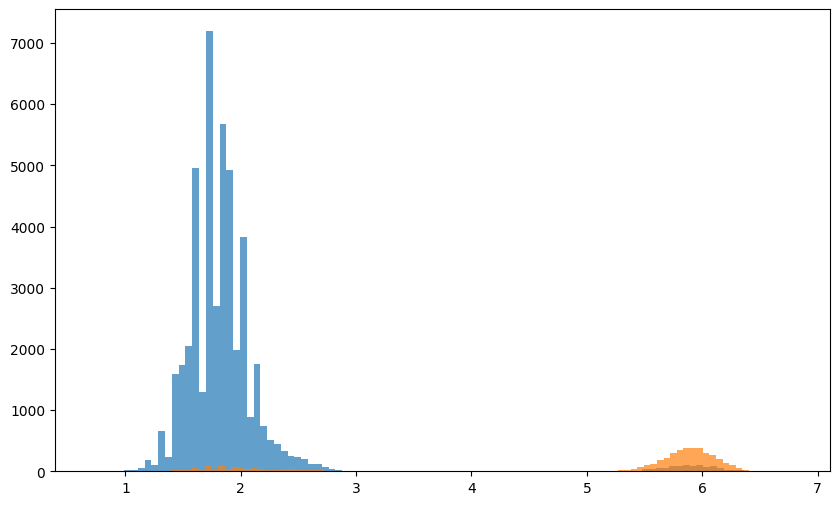

In [30]:
scores_inliers = anomaly_scores[y_gm_test == 0]  # Assuming '0' is the label for inliers
scores_outliers = anomaly_scores[y_gm_test == 1]  # Assuming '1' is the label for outliers
# Create the plots
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot for inliers
plt.hist(scores_inliers, bins=100, alpha=0.7, label='Inliers')

# Plot for outliers
plt.hist(scores_outliers, bins=100, alpha=0.7, label='Outliers')

Functions

In [ ]:

def plot_graph_scenario(metrics_dict, supervision_rate_list):
    fig, axes = plt.subplots(2,1,figsize=(14, 8))  # Create a figure and a set of subplots.
    ax_n = 0
    for metric_type in metrics_dict:
        curr_ax = axes[ax_n]
        ax_n +=1

        # Assuming metrics_dict['roc_auc'] contains the ROC AUC values for each IP
        ips = list(metrics_dict[metric_type].keys())
        n_ips = len(ips)
        n_supervision_rates = len(supervision_rate_list)

        # Create a numpy array to hold the ROC AUC values
        roc_aucs = np.zeros((n_ips, n_supervision_rates))
        
        for i, ip in enumerate(ips):
            for j, sr in enumerate(supervision_rate_list):
                roc_aucs[i, j] = metrics_dict[metric_type][ip][sr]

        # Create the bar width
        bar_width = 0.15
        index = np.arange(n_ips)

        # Plot bars for each supervision rate
        for j, sr in enumerate(supervision_rate_list):
            curr_ax.bar(index + j * bar_width, roc_aucs[:, j], bar_width, label=f'Supervision Rate: {sr}')

        curr_ax.set_title('ROC AUC Comparison by IP and Supervision Rate')
        curr_ax.set_xlabel('IP Address')
        curr_ax.set_ylabel('AUC')
        curr_ax.set_xticks(index + bar_width * (n_supervision_rates - 1) / 2)
        curr_ax.set_xticklabels(ips, rotation=45)
        curr_ax.legend()
        curr_ax.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
from functools import partial
from modAL.batch import uncertainty_batch_sampling

def lm_eval_2(Xgmm_test_dvc, gm_pred, lm_clf):
    train_perc = 0.6
    Xlm_train, Xlm_test, ylm_train, ylm_test = train_test_split(Xgmm_test_dvc, 
                                                        gm_pred, 
                                                        test_size=1 - train_perc, 
                                                        shuffle=True, 
                                                        stratify=gm_pred, 
                                                        random_state=42)    
    if lm_clf == "Comittee":
        # initializing Committee members
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):

            # initializing learner
            learner = ActiveLearner(
                estimator=RandomForestClassifier(),
                X_training=Xlm_train, y_training=ylm_train,
            )
            learner_list.append(learner)        
        lm_clf = Committee(learner_list=learner_list)
        predictions = lm_clf.predict(Xlm_test)    
    else:
        # Train the classifier on the training data
        lm_clf.fit(Xlm_train, ylm_train)    
        
        predictions = lm_clf.predict(Xlm_test)

        
    # Evaluate accuracy
    accuracy = accuracy_score(ylm_test, predictions)
    print(f"Accuracy: {accuracy}")
    return accuracy, lm_clf, Xlm_train, ylm_train
# Read the csv and clean it
def train_gm(Xgm_train_scaled, y_train, supervision_rate, model):


    # Prepare labels for semi-supervised learning
    idx = np.where(y_train == 1)[0]
    y = np.zeros_like(y_train.values)
    y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
    # Train the model
    path = f"gm_1_{supervision_rate}.pkl"
    if os.path.exists(path):
        with open(path, 'rb') as f:
            clf = pickle.load(f)
    else:
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=Xgm_train_scaled.to_numpy(), y=y_train)  
            
            # with open(path, 'wb') as f:
                # pickle.dump(clf, f)
    return clf
def train_lm(victim_IP, Xgmm_test, y_test, scaler, gm_clf,lm_clf, method = "Normal"):
    # Load Model Instead      
    # dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
    #                 'Dst Port', 'Timestamp', 'Dvc Label']            
    # Create a fresh copy of the DataFrame for each IP and supervision rate
    roc_auc, curr_X_test_scaled, gm_pred, gm_opt_threshold = perform_inference(Xgmm_test, y_test, dropping_cols, scaler, gm_clf)
    print(f"gm_opt_threshold is {gm_opt_threshold}")
    acc, updated_lm_clf, Xlm_train, Ylm_train = lm_eval_2(curr_X_test_scaled, gm_pred, lm_clf)
    return updated_lm_clf, gm_opt_threshold, Xlm_train, Ylm_train



# Perform New Attack Classification using Local Model (Obtain)
def new_attacks_inference(lm_clf, Xnew_train, ynew_train, scaler):

        cart_predictions = lm_clf.predict(Xnew_train)
        # Evaluate accuracy
        accuracy = accuracy_score(ynew_train, cart_predictions)
        print(f"Accuracy before update: {accuracy}")
        
        # Get Confidence Point
        # Get the indices of the samples where the actual label doesn't match the predicted label
        mismatch_indices = [i for i, (actual, cart_predictions) in enumerate(zip(ynew_train, cart_predictions)) if actual != cart_predictions]

        uncertain_count = 0
        cart_probabilities = lm_clf.predict_proba(Xnew_train)

        return accuracy, cart_probabilities, mismatch_indices 

def active_learning_query(lm_clf, Xnew_train, ynew_train, scaler):
    pass
    #Use Stream-Based Sampling, however instead of 1 by 1, get the whole pool

        # X_pool = Xnew_train.copy()
        # y_pool = ynew_train.copy()
        # for idx in range(n_queries):
        #     query_idx, query_instance = lm_clf.query(X_pool)
        #     lm_clf.teach(
        #         X=X_pool[query_idx].reshape(1, -1),
        #         y=y_pool[query_idx].reshape(1, )
        #     )
        #     performance_history.append(lm_clf.score())
        #     # remove queried instance from pool
        #     X_pool = np.delete(X_pool, query_idx, axis=0)
        #     y_pool = np.delete(y_pool, query_idx)     
        # predictions = lm_clf.predict(X_pool)     
        
    

# Forward Low confidence data to GM and Label (Get GM Accuracy)
def get_low_confidence_data(cart_probabilities, mismatch_indices, threshold=1):
    if threshold == 1:
        forward_gm_idx = np.where((cart_probabilities[:, 0] != threshold) & (cart_probabilities[:, 0] !=  threshold))
    else: 
        forward_gm_idx = np.where((cart_probabilities[:, 0] > threshold) & (cart_probabilities[:, 0] <  1-threshold))
    print(f"Total Uploaded Data {len(forward_gm_idx[0])}")
    # How many Misclassified data is inconfident
    set_mismatch_indices = set(list(mismatch_indices))
    set_forward_gm_idx = set(forward_gm_idx[0].tolist())
    x = len(set_mismatch_indices.intersection(set_forward_gm_idx))
    print(f"Percentage of misclassied data that is uploaded: {x/len(mismatch_indices)}")
    print(f"Total Data Uploaded: {len(forward_gm_idx[0])/len(cart_probabilities)}")
    # print(f"Correctly Detected / Uploaded data: {(x/len(forward_gm_idx[0]))}")  
    return forward_gm_idx

# Upload to label and Perform Training on CART_Classifier
def upload_gm(X_forward, y_forward, gm_clf, lm_clf, gm_opt_threshold, orig_Xlm_train, orig_Ylm_train):
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    initial_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, initial_gm_pred)
    print(f'Accuracy of GM before update: {accuracy}')
    
    # Convert numpy arrays to DataFrames
    X_forward_df = pd.DataFrame(X_forward, columns = orig_Xlm_train.columns )
    y_forward_df = pd.DataFrame(np.zeros(initial_gm_pred.shape[0]), columns=["Label"])

    # Concatenate with original DataFrames
    Xtrain = pd.concat([pd.DataFrame(orig_Xlm_train), X_forward_df], axis=0)
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), y_forward_df])
    Xtrain.columns = orig_Xlm_train.columns
    # return Xtrain, Ytrain
    # Update GM
    gm_clf = train_gm(orig_Xlm_train, orig_Ylm_train, supervision_rate, PReNet)
    # Inference using updated GM
    anomaly_scores = gm_clf.decision_function(X=X_forward)
    updated_gm_pred = np.where(anomaly_scores > gm_opt_threshold, 1,0)
    accuracy = accuracy_score(y_forward, updated_gm_pred)
    print(f'Accuracy of GM after update: {accuracy}')  
    
    Ytrain = pd.concat([pd.DataFrame(orig_Ylm_train, columns=["Label"]), pd.DataFrame(updated_gm_pred, columns=["Label"])])  
    lm_clf = XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1)
    # continued_model.fit(X_forward_df, y_forward_df, xgb_model=lm_clf.get_booster())    
    # continued_model.fit(Xtrain, Ytrain)
    lm_clf.fit(Xtrain, Ytrain)
    return lm_clf
# Evaluate Accuracy with new attack data
def eval_updated_lm(Xnew_test, ynew_test, new_lm_clf):
    pred = new_lm_clf.predict(Xnew_test)
    acc = accuracy_score(ynew_test, pred)
    print(f'Accuracy of updated LM: {acc}')


ModuleNotFoundError: No module named 'modAL'

In [ ]:
# Read the csv and clean it
def eval_model_unsupervised(improved_df, supervision_rate_list, model, victim_IP):
    anomaly_rate = 0.05
    metrics_dict = {
        'roc_auc': {ip : {sr : 0 for sr in supervision_rate_list} for ip in victim_IP}
    }
    X_train, X_test, y_train, y_test, scaler = process_dataset(improved_df, anomaly_rate)

    for supervision_rate in supervision_rate_list:
        # Prepare labels for semi-supervised learning
        idx = np.where(y_train == 1)[0]
        y = np.zeros_like(y_train.values)

        y = set_supervised_label(supervision_rate, anomaly_rate, y, idx)
            
        dropping_cols = ['Protocol', 'id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                        'Dst Port', 'Timestamp', 'Dvc Label']
        X_train.drop(dropping_cols, axis = 1, inplace = True)     
        
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns) 
        
        # Train the model
        clf = model(device='cuda', verbose=1, epochs=1)
        clf.fit(X=X_train_scaled.to_numpy(), y=y)        
        
        for curr_ip in victim_IP:
            # Create a fresh copy of the DataFrame for each IP and supervision rate

            roc_auc = perform_inference(X_test, y_test, curr_ip, dropping_cols, scaler, clf)
            # Store metrics
            metrics_dict['roc_auc'][curr_ip][supervision_rate] += roc_auc 

    return metrics_dict
